# Setup

In [1]:
! pip install -q datasets
! pip install -q nltk
! pip install -q sentence-transformers
! pip install -q pandas
! pip install -q evaluate

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
from datasets import load_dataset, DatasetDict
import pandas as pd

# Data preprocessing

In [7]:
dataset = DatasetDict()
dataset["train"] = load_dataset("legacy107/qa_wikipedia", split="train[80%:]")
dataset["validation"] = load_dataset("legacy107/qa_wikipedia", split="validation[80%:]")
dataset["test"] = load_dataset("legacy107/qa_wikipedia", split="test[80%:]")

In [ ]:
dataset

In [ ]:
import nltk

nltk.download("punkt")

article_cache = {}


def chunk_text(row, chunk_size=100, overlap=0.20):
    global article_cache

    overlap_size = chunk_size * overlap

    if row["title"] in article_cache.keys():
        row["chunked_article"] = article_cache[row["title"]]
        return row

    sentences = nltk.sent_tokenize(row["article"])

    chunks = []
    text = sentences[0]
    i = 1
    while i < len(sentences):
        text += " " + sentences[i]
        i += 1
        while (
            i < len(sentences)
            and len(nltk.word_tokenize(f"{text} {sentences[i]}")) <= chunk_size
        ):
            text += " " + sentences[i]
            i += 1

        text = (
            text.replace('"', '"')
            .replace("'", "'")
            .replace("\n\n\n", " ")
            .replace("\n\n", " ")
            .replace("\n", " ")
        )
        chunks.append(text)

        if i >= len(sentences):
            break

        j = i - 1
        text = sentences[j]
        while (
            j >= 0 and len(nltk.word_tokenize(f"{sentences[j]} {text}")) <= overlap_size
        ):
            text = sentences[j] + " " + text
            j -= 1

    row["chunked_article"] = chunks
    article_cache[row["title"]] = chunks

    return row

In [ ]:
dataset = dataset.map(chunk_text, batched=False)

<Axes: >

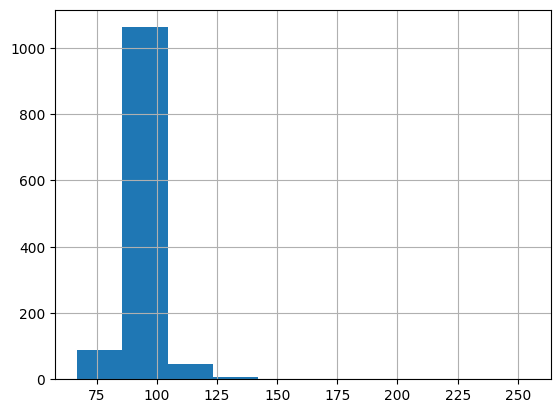

In [20]:
# convert dictionary to dataframe
df = pd.DataFrame(list(article_cache.items()), columns=["title", "chunked_article"])
df["avg_chunk_length"] = df["chunked_article"].apply(
    lambda x: sum(len(nltk.word_tokenize(chunk)) for chunk in x) / len(x)
)
df["avg_chunk_length"].hist()

In [ ]:
dataset.push_to_hub("legacy107/sentence_transformer_wikipedia_chunked")

# Prepare triplets

In [ ]:
dataset = load_dataset("legacy107/sentence_transformer_wikipedia_chunked")

In [ ]:
import nltk
import evaluate

nltk.download("punkt")
squad_metric = evaluate.load("squad")


def compute_f1(anchor, chunk):
    predictions = [{"prediction_text": chunk, "id": "0"}]
    references = [
        {
            "answers": {"answer_start": [-1], "text": [anchor]},
            "id": "0",
        }
    ]
    results = {}
    results["squad"] = squad_metric.compute(
        predictions=predictions, references=references
    )

    return results


def compose_triplet(row):
    sentences = nltk.sent_tokenize(row["context"])
    chunks = row["chunked_article"]

    max_sentence_matches = 0
    max_chunk = None

    min_sentence_matches = 0
    min_chunk = None

    for chunk in chunks:
        sentence_matches = 0
        for sentence in sentences:
            if sentence in chunk:
                sentence_matches += 1
        if max_chunk is None or sentence_matches > max_sentence_matches:
            max_chunk = chunk
            max_sentence_matches = sentence_matches

        if min_chunk is None or sentence_matches < min_sentence_matches:
            min_chunk = chunk
            min_sentence_matches = sentence_matches

    row["anchor"] = row["question"]
    row["positive"] = max_chunk
    row["negative"] = min_chunk

    return row

In [ ]:
dataset = dataset.map(
    compose_triplet,
    batched=False,
    remove_columns=[
        "id",
        "title",
        "question",
        "answer_start",
        "answer",
        "article",
        "chunked_article",
    ],
)

In [44]:
dataset["train"][0]

{'context': 'Another is used for "calculating" the multiples of 9 up to 9 × 10 using one\'s fingers. Begin by holding out both hands with all fingers stretched out. Now count left to right the number of fingers that indicates the multiple. For example, to figure 9 × 4, count four fingers from the left, ending at your left-hand index finger. Bend this finger down and count the remaining fingers. Fingers to the left of the bent finger represent tens, fingers to the right are ones. There are three fingers to the left and six to the right, which indicates 9 × 4 = 36. This works for 9 × 1 up through 9 × 10.',
 'anchor': 'what is the multiples of fingers ?',
 'positive': 'Begin by holding out both hands with all fingers stretched out. Now count left to right the number of fingers that indicates the multiple. For example, to figure 9 × 4, count four fingers from the left, ending at your left-hand index finger. Bend this finger down and count the remaining fingers. Fingers to the left of the b

In [ ]:
dataset.filter(lambda x: x["context"] != x["positive"])

In [ ]:
dataset.push_to_hub("legacy107/qa_wikipedia_sentence_transformer")

# Finetune sentence transformer

In [ ]:
from sentence_transformers import (
    SentenceTransformer,
    models,
    InputExample,
    losses,
    evaluation,
)
from torch.utils.data import DataLoader
from datasets import load_dataset

In [4]:
username = "legacy107"
checkpoint = "multi-qa-mpnet-base-dot-v1-wikipedia-search"
dataset_nm = "legacy107/qa_wikipedia_sentence_transformer"
dataset = load_dataset(dataset_nm)

In [5]:
model = SentenceTransformer("sentence-transformers/multi-qa-mpnet-base-dot-v1")

In [7]:
train_examples = []
n_examples = dataset["train"].num_rows

for i in range(n_examples):
    example = dataset["train"][i]
    train_examples.append(
        InputExample(
            texts=[example["anchor"], example["positive"], example["negative"]]
        )
    )

In [8]:
batch_size = 8
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
train_loss = losses.TripletLoss(model=model)
num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data

In [ ]:
evaluator = evaluation.TripletEvaluator(
    anchors=dataset["validation"]["anchor"],
    positives=dataset["validation"]["positive"],
    negatives=dataset["validation"]["negative"],
    show_progress_bar=True,
    batch_size=batch_size,
)

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    output_path=f"./{checkpoint}",
    checkpoint_path=f"./{checkpoint}",
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    evaluator=evaluator,
    evaluation_steps=500,
    save_best_model=True,
)

In [ ]:
# model.save_to_hub doesn't work with the latest version of huggingface_hub

from huggingface_hub import HfApi

api = HfApi()
# api.create_repo(repo_id=checkpoint)
root_path = "/kaggle/working/"
checkpoint_number = 16000

files_to_push_to_hub = [
    "README.md",
    "modules.json",
    "config.json",
    "config_sentence_transformers.json",
    "modules.json",
    "pytorch_model.bin",
    "sentence_bert_config.json",
    "special_tokens_map.json",
    "tokenizer.json",
    "tokenizer_config.json",
    "vocab.txt",
]

for filename in files_to_push_to_hub:
    api.upload_file(
        path_or_fileobj=f"{root_path}/{checkpoint}/{checkpoint_number}/{filename}",
        repo_id=f"{username}/{checkpoint}",
        path_in_repo=filename,
        repo_type="model",
    )

api.upload_folder(
    folder_path=f"{root_path}/{checkpoint}/{checkpoint_number}/1_Pooling",
    path_in_repo="1_Pooling",
    repo_id=f"{username}/{checkpoint}",
    repo_type="model",
)

In [ ]:
# model.save_to_hub doesn't work with the latest version of huggingface_hub

from huggingface_hub import HfApi

api = HfApi()
# api.create_repo(repo_id=checkpoint)
root_path = "/kaggle/working/"
checkpoint_number = 16000

files_to_push_to_hub = [
    "README.md",
    "modules.json",
    "config.json",
    "config_sentence_transformers.json",
    "modules.json",
    "pytorch_model.bin",
    "sentence_bert_config.json",
    "special_tokens_map.json",
    "tokenizer.json",
    "tokenizer_config.json",
    "vocab.txt",
]

for filename in files_to_push_to_hub:
    api.upload_file(
        path_or_fileobj=f"{root_path}/{checkpoint}/{checkpoint_number}/{filename}",
        repo_id=f"{username}/{checkpoint}",
        path_in_repo=filename,
        repo_type="model",
    )

api.upload_folder(
    folder_path=f"{root_path}/{checkpoint}/{checkpoint_number}/1_Pooling",
    path_in_repo="1_Pooling",
    repo_id=f"{username}/{checkpoint}",
    repo_type="model",
)

# Evaluate

In [ ]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util

In [ ]:
dataset = load_dataset("legacy107/sentence_transformer_wikipedia_chunked", split="test")

In [ ]:
# checkpoint_nm = 'sentence-transformers/multi-qa-mpnet-base-dot-v1'
checkpoint_nm = f"{username}/{checkpoint}"
bi_encoder = SentenceTransformer(checkpoint_nm)
bi_encoder.max_seq_length = 256  # Truncate long passages to 256 tokens
top_k = 10  # Number of passages we want to retrieve with the bi-encoder

# The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
# cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [ ]:
embedding_cache = {}


def retrieve_context(row):
    global embedding_cache

    if row["title"] in embedding_cache.keys():
        corpus_embeddings = embedding_cache[row["title"]]
    else:
        corpus_embeddings = bi_encoder.encode(
            row["chunked_article"], convert_to_tensor=True, show_progress_bar=False
        )
        embedding_cache[row["title"]] = corpus_embeddings

    query = row["question"]

    question_embedding = bi_encoder.encode(
        query, convert_to_tensor=True, show_progress_bar=False
    )
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]
    hits = sorted(hits, key=lambda x: x["score"], reverse=True)

    row["retrieved_context"] = " ".join(
        [row["chunked_article"][hit["corpus_id"]] for hit in hits[0:3]]
    ).replace("\n", " ")

    return row

In [ ]:
dataset = dataset.map(retrieve_context, batched=False)

In [ ]:
match = 0


def find_match(row):
    global match
    match = match + (1 if row["answer"] in row["retrieved_context"] else 0)


dataset.map(find_match, batched=False)

print("%.2f" % (match / dataset.num_rows * 100))

* pretrained model: 75.40
* finetuned model: 27.60